In [1]:
%matplotlib inline
from IPython.display import clear_output

import gc
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras import initializers
import sys
sys.path.append('/home/art/Programming/artlibs')
from artiom_convenience_functions import * 
from videorecorder import save_to_video, execute_at_exit



2022-10-05 17:10:15.893464: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 17:10:16.508836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/art/venv/neural.env/lib/python3.10/site-packages/cv2/../../lib64::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/home/art/.local/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/home/art/.local/lib
2022-10-05 17:10:16.508927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/art/venv/neural.env/lib/python3.10/site-packages/cv2/../../lib

In [2]:
def s(img):
    plt.imshow(
    img.reshape(
    N_DIM, N_DIM), cmap='gray')

In [3]:
N_DIM = 64

# faces = np.concatenate([np.fromfile(f"girls_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255,

#                         np.fromfile(f"boys_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255])

In [4]:
faces = np.fromfile("/home/art/datasets/celeb_faces_64x64_200k.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255

In [5]:
faces.shape

(197122, 64, 64)

# Face generator


In [6]:
inputs = keras.Input(shape=(100))
x = Dense(100, activation='sigmoid', kernel_regularizer='l2', use_bias=0)(inputs)
#x = Dropout(0.2)(x)
#x = Dense(1000, activation='sigmoid')(x)

x = Dense(4*(N_DIM + 1)** 2, activation='sigmoid', kernel_regularizer='l2', use_bias=0)(x)
x = Reshape((2*N_DIM + 2, 2*N_DIM + 2, 1))(x)

x = Conv2D(300, (3, 3),)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(1, (1, 1), activation="sigmoid")(x)
print(x.shape)

print(x.shape)
x = Reshape((N_DIM, N_DIM))(x)
face_gen = keras.Model(inputs=inputs, outputs=x, name="face_generator")

(None, 64, 64, 1)
(None, 64, 64, 1)


2022-10-05 17:10:19.924780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 17:10:19.967487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 17:10:19.968102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 17:10:19.969581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 17:10:19.969742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [7]:
face_gen.compile(

    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"],
)


# policeman 

In [8]:
shape=(N_DIM, N_DIM)

In [9]:
inputs = keras.Input(shape=(N_DIM, N_DIM, 1))

x = Conv2D(100, (3, 3))(inputs)
x = MaxPool2D((2, 2))(x)

x = Conv2D(108, (5, 5))(x)
x = MaxPool2D((3, 3))(x)
#x = Conv2D(30, (4, 4))(x)
#x = MaxPool2D((4, 4))(x)


x = Flatten()(x)
x = Dense(50, activation='sigmoid', kernel_regularizer='l2', )(x)


outputs = Dense(1, activation='sigmoid')(x)
policeman = keras.Model(inputs=inputs, outputs=outputs, name="policeman")

In [10]:

policeman.compile(
    loss=keras.losses.BinaryCrossentropy(),

    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"],
)

# Среда

In [11]:
policeman.trainable = False
inputs = keras.Input(shape=(100))
x = face_gen(inputs)
outputs = policeman(x) 
env_model = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

In [12]:

env_model.compile( loss="binary_crossentropy" 
)

In [13]:
env_model.summary()

Model: "face_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 face_generator (Functional)  (None, 64, 64)           1703301   
                                                                 
 policeman (Functional)      (None, 1)                 708609    
                                                                 
Total params: 2,411,910
Trainable params: 1,703,301
Non-trainable params: 708,609
_________________________________________________________________


2022-10-05 17:10:21.795159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-05 17:10:22.569816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1/1 [==============================] - 3s 3s/step


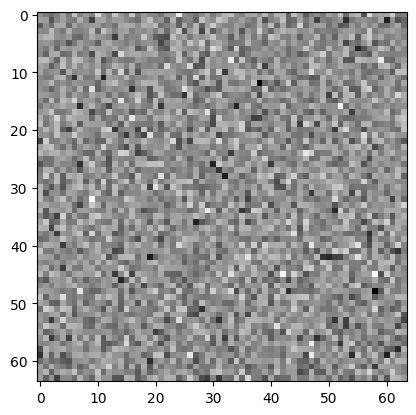

In [14]:
s(
    face_gen.predict(
        np.random.random(size=100).astype("float32").reshape(1, 100)
    ).reshape(N_DIM, N_DIM))

# Учим полицейского

In [15]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

In [16]:
faces_drawn_from_seeds = face_gen.predict(seeds)

10/10 [==============================] - 0s 16ms/step


In [17]:

indices = np.random.randint(0, len(faces), size=N)
real_faces = faces[indices]

In [18]:
X = np.concatenate([faces_drawn_from_seeds, real_faces])
X.shape

(628, 64, 64)

In [19]:
Y = np.zeros(
N * 2)

Y[N:] = 1

In [20]:
X[1]

array([[0.5033775 , 0.50321341, 0.50319189, ..., 0.50383019, 0.50320971,
        0.50316912],
       [0.50351757, 0.50349528, 0.50297278, ..., 0.50342751, 0.50308025,
        0.50318408],
       [0.50315428, 0.50339437, 0.50324172, ..., 0.50328791, 0.5036093 ,
        0.50308532],
       ...,
       [0.50360405, 0.50323039, 0.50360668, ..., 0.50348359, 0.50349158,
        0.50334007],
       [0.50344032, 0.50369054, 0.50305855, ..., 0.50378579, 0.50338101,
        0.50326747],
       [0.50337923, 0.50312573, 0.5033924 , ..., 0.50373846, 0.50361651,
        0.50350797]])

0.0


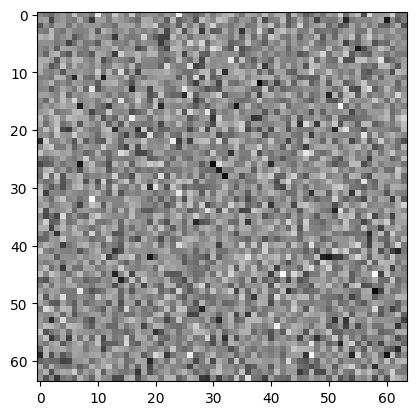

In [21]:
x, y = X[ind:=np.random.randint(0, len(X))],   Y[ind]
print(y)
s(x)

In [22]:
policeman.fit(X, Y, epochs=1, shuffle=1)
policeman.evaluate(X, Y)

20/20 [==============================] - 0s 5ms/step - loss: 1.4575 - accuracy: 0.9889


[1.4575356245040894, 0.9888535141944885]

# Теперь запускаем срелу

In [23]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

ones = np.ones(len(seeds), dtype="float32").reshape(-1, 1)


In [24]:
ones.shape

(314, 1)

In [25]:

seeds[0]

array([0.3005854 , 0.8220936 , 0.3570678 , 0.8345889 , 0.92042327,
       0.606228  , 0.3883233 , 0.45871773, 0.65832317, 0.08467247,
       0.03862334, 0.9250967 , 0.57736903, 0.18729094, 0.8222554 ,
       0.30091372, 0.13218974, 0.8443813 , 0.32490578, 0.2692907 ,
       0.95771444, 0.6433937 , 0.29105252, 0.11172686, 0.24861462,
       0.48411262, 0.0480495 , 0.9683301 , 0.8738027 , 0.14353652,
       0.60077673, 0.2171317 , 0.29233572, 0.35743043, 0.30326214,
       0.01973488, 0.8806322 , 0.60079587, 0.10416752, 0.7285683 ,
       0.6095759 , 0.8788154 , 0.6048366 , 0.13098317, 0.0426972 ,
       0.7223777 , 0.53410363, 0.560719  , 0.20048451, 0.6624716 ,
       0.6763889 , 0.41606688, 0.20859393, 0.24210854, 0.5476966 ,
       0.00703315, 0.5923755 , 0.88861465, 0.6904062 , 0.33631077,
       0.40601817, 0.38712373, 0.7152402 , 0.9026043 , 0.60206276,
       0.92927957, 0.5898169 , 0.03160596, 0.78150463, 0.8507666 ,
       0.6610222 , 0.5911437 , 0.23277687, 0.42098182, 0.59102

In [26]:
env_model.fit(seeds, ones, shuffle=1, epochs=1)

10/10 [==============================] - 3s 171ms/step - loss: 2.8481


# В цикле

In [27]:
env_model.learning_rate = 1299

In [28]:
faces_drawn_from_seeds[0]

array([[0.50334793, 0.50325006, 0.5031371 , ..., 0.503816  , 0.5032374 ,
        0.50324965],
       [0.5034881 , 0.5034922 , 0.5029656 , ..., 0.50339556, 0.5030167 ,
        0.5032242 ],
       [0.5030876 , 0.5033593 , 0.50319135, ..., 0.50333464, 0.50369877,
        0.5030469 ],
       ...,
       [0.50355214, 0.50322187, 0.5036451 , ..., 0.5034205 , 0.5034773 ,
        0.50329685],
       [0.50341386, 0.50369215, 0.50304234, ..., 0.5038243 , 0.50338936,
        0.50326   ],
       [0.5033784 , 0.5030446 , 0.5033877 , ..., 0.5037194 , 0.50369304,
        0.5034453 ]], dtype=float32)

In [29]:
from importlib import reload

from videorecorder import get_new_cv2_imshow
from videorecorder import save_to_video, execute_at_exit

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )

In [30]:
2

2

In [ ]:

cv2.destroyAllWindows()
from importlib import reload

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
#from videorecorder import save_to_video, execute_at_exit
from artiom_convenience_functions import *

from videorecorder import get_new_cv2_imshow
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )




key = None
policeman_epochs = 1
env_epochs = 10


vis_seeds = np.random.random(size=(3, 100)).astype("float32").reshape(-1, 100)


while key not in (27,):
    N = 200
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)
    faces_drawn_from_seeds = face_gen.predict(seeds, verbose=0)

    
    
    # Вывод N лиц
    vis_seeds = np.random.random(size=(3, 100)).astype("float32").reshape(-1, 100)
    vis_faces = face_gen.predict(vis_seeds, verbose=0)
    vis_faces = vis_faces.transpose((1, 0, 2)).reshape(N_DIM, -1)
    illustration_img = uint8_normalized(cv2.cvtColor(
        
        fit_img_center(vis_faces, width=1500, height=800,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
    my_imshow("result", illustration_img)
    #send_to_artmonitor(illustration_img, secret="artgan")
#     save_to_video((faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
#                                interpolation=cv2.INTER_NEAREST))
    key = cv2.waitKey(1)

    indices = np.random.randint(0, len(faces), size=N)
    real_faces = faces[indices]
    X = np.concatenate([faces_drawn_from_seeds, real_faces])
    Y = np.zeros(
    N * 2)

    Y[N:] = 1

    
    

    policeman.fit(X, Y, epochs=int(policeman_epochs), shuffle=1, verbose=0)
    caught = policeman.evaluate(X, Y, verbose=0)[1]
    print(caught, policeman_epochs, env_epochs)






    N = 200
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

    ones = np.ones(len(seeds)).reshape(-1, 1)
    
    if caught > 0.9:
          env_epochs = policeman_epochs * 1.5
    elif caught < 0.6:
        
        policeman_epochs = env_epochs * 1.5
        
        
    if env_epochs > 10 and policeman_epochs > 10:
        env_epochs /= 2
        policeman_epochs /= 2
    env_model.fit(seeds, ones, shuffle=1, epochs=int(env_epochs), verbose=0)
    

cv2.destroyAllWindows()
execute_at_exit()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0.9424999952316284 1 10
0.8849999904632568 1 1.5
0.9599999785423279 1 1.5
0.8475000262260437 1 1.5
1.0 1 1.5
1.0 1 1.5
0.9775000214576721 1 1.5
1.0 1 1.5
0.9925000071525574 1 1.5
0.9725000262260437 1 1.5
0.48249998688697815 1 1.5
0.9049999713897705 2.25 1.5
0.9599999785423279 2.25 3.375
0.7225000262260437 2.25 3.375
0.4675000011920929 2.25 3.375
0.9975000023841858 5.0625 3.375
0.9325000047683716 5.0625 7.59375
1.0 5.0625 7.59375
0.9150000214576721 5.0625 7.59375
1.0 5.0625 7.59375
0.5 5.0625 7.59375
0.9925000071525574 11.390625 7.59375
0.5 5.6953125 8.54296875
0.5 12.814453125 8.54296875
0.9925000071525574 12.814453125 8.54296875
0.4975000023841858 6.4072265625 9.61083984375
1.0 14.416259765625 9.61083984375
0.5 7.2081298828125 10.81219482421875
0.9750000238418579 8.109146118164062 5.406097412109375
0.5 8.109146118164062 12.163719177246094
0.5 9.12278938293457 6.081859588623047
0.6899999976158142 9.12278938293457 6.081859588623047
1.0 9.12278938293457 6.081859588623047
0.5 9.1227893829

In [ ]:
vis_seeds = np.random.random(size=(3, 100)).astype("float32").reshape(-1, 100)
vis_faces = face_gen.predict(vis_seeds, verbose=0)

In [ ]:
plt.imshow(vis_faces.transpose((1, 0, 2)).reshape(N_DIM, -1))

In [ ]:
execute_at_exit()

### Сохранение моделей

In [ ]:
face_gen.save(f"Первый прилично работающий генератор для GANа лиц {date_time_filename()}.h5")

In [ ]:
env_model.save(f"Первый прилично работающий GAN лиц {date_time_filename()}.h5")

### Восстановление состояния из сохраненной модели

In [ ]:

face_gen.load_weights("./Первый прилично работающий генератор для GANа лиц Thu_Sep_29_04-23-30_2022.txt.h5")

In [ ]:
env_model.load_weights("./Первый прилично работающий GAN лиц Wed_Sep_28_16-04-26_2022.txt.h5")